# Desafio de Programação 5: Reconhecimento de Imagem com Redes Neurais Convolucionais

## Identificação:

**Nome: Daniel Toledo Dantas**

**Matrícula: 211068477**

## Introdução

Neste exercício, nós utilizaremos Redes Neurais Convolucionais para implementar um algoritmo que consiga fazer distinção entre raças de cães a partir de imagens.

Primeiramente, utilizaremos a biblioteca `fastai`, na Parte 1, para classificar imagens de cães e gatos.

Em seguida, executaremos a tarefa de distinguir cães de raças diferentes implementando uma rede neural em Pytorch na Parte 2.

Por fim, na Parte 3, nós aplicaremos a técnica de Transfer Learning para implementar um algoritmo que consiga classificar imagens de cães de diferentes raças.

Todas as informações necessárias para resolver esta tarefa estão neste ambiente e todas as partes do código devem ser implementadas ao longo deste notebook.

Antes de iniciarmos o exercício, nós precisamos que algumas bibliotecas já estejam disponíveis. São elas:

- Numpy: (http://www.numpy.org/) para todas as operações matriciais;
- Matplotlib: (https://matplotlib.org/) para a plotagem dos gráficos;

Mas antes, nós configuraremos o ambiente, permitindo o acesso ao seu Google Drive, de onde serão importados os datasets e as imagens do notebook, além de outros módulos adicionais.


A célula abaixo irá "montar" o drive dentro do Google Colaboratory, ou seja, conseguiremos acessar diretamente todos os conteúdos presentes no Google drive, possibilitando a execução do *Jupyter Notebook* a partir, unicamente, da nuvem.


In [1]:
#allows the drive to be accessed
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import sys

#!cat '/content/drive/MyDrive/Desafios de programacao - TopEng 2_2023/Desafio de programação 5/utils.py'
!cat '/content/drive/MyDrive/TopEng/DP5/utils.py'
#sys.path.append('/content/drive/MyDrive/Desafios de programacao - TopEng 2_2023/Desafio de programação 5')
sys.path.append('/content/drive/MyDrive/TopEng/DP5')

import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcdefaults()
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle

NumDots = 4
NumConvMax = 24
NumFcMax = 10
White = 1.
Light = 0.7
Medium = 0.5
Dark = 0.3
Darker = 0.15
Black = 0.


def add_layer(patches, colors, size=(24, 24), num=5,
              top_left=[0, 0],
              loc_diff=[10, -10],
              ):
    # add a rectangle
    top_left = np.array(top_left)
    loc_diff = np.array(loc_diff)
    loc_start = top_left - np.array([0, size[0]])
    for ind in range(num):
        patches.append(Rectangle(loc_start + ind * loc_diff, size[1], size[0]))
        if ind % 2:
            colors.append(Medium)
        else:
            colors.append(Light)


def add_layer_with_omission(patches, colors, size=(24, 24),
                            num=5, num_max=8,
                            num_dots=4,
                            top_left=[0, 0],
              

Com o acesso permitido ao drive e com o ambiente preparado, podemos iniciar a importação das bibliotecas de Python que serão utilizadas no nosso código.

In [3]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# tells matplotlib to embed plots within the notebook
%matplotlib inline

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# Pytorch
import torch

# modules to dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# modules to adequate the NN
from torch import nn
from torch import optim

# Measuring execution time
import time


Recomendamos que, antes de iniciar o treinamento da rede, você habilite uma GPU para executar o programa. Isso porque a arquitetura da rede neural usada aqui é bastante complexa e, por isso, apresenta um custo computacional bem maior quando comparada aos exemplos anteriores.

Sabemos que nem todos possuem GPU na máquina, mas, para nossa sorte, o Google Colaboratory permite a utilização de unidades de processamento (GPU ou TPU) de forma gratuita.

Para habilitar essa função, basta acessar na parte superior da página do Colab: **Ambiente de execução > Alterar o tipo de ambiente de execução > Acelerador de hardware**, selecionar a opção “**GPU**” e salvar.

Pronto, agora a célula responsável por procurar uma unidade de processamento verificará que a GPU está habilitada e fará uso desse _hardware accelerator_ para processar o código, obtendo uma solução bem mais rápida.

In [4]:
def testar_gpu():
	train_on_gpu = torch.cuda.is_available() #Observa se a GPU está disponivel
	if train_on_gpu: #Se sim
		device = torch.device('cuda') #Seleciona o device como GPU
		print("Treinando na GPU") #E manda a mensagem
	else: #Se não
		device = torch.device('cpu') #Seleciona o device como cpu
		print("GPU indisponível, treinando na CPU") #E avisa que a GPU não esta disponível
	return device

device = testar_gpu()

Treinando na GPU


## 1 FastAI

O FastAI é uma biblioteca de Machine Learning que visa simpificar ao máximo a   criação de redes neurais, possibilitando a implementação de algoritmos eficientes de inteligência artifical de forma rápida e simples.

Iniciaremos esta tarefa fazendo a instalação da biblioteca *fastai*. Execute a célula abaixo que fará isso automaticamente.

In [5]:
pip install git+https://github.com/fastai/fastai.git

  Cloning https://github.com/fastai/fastai.git to /tmp/pip-req-build-x3767c3w
  Running command git clone --filter=blob:none --quiet https://github.com/fastai/fastai.git /tmp/pip-req-build-x3767c3w
  Resolved https://github.com/fastai/fastai.git to commit 96f0e2027c8fd82eef40984faf14c1c81e0eb031
  Preparing metadata (setup.py) ... done


Com a instalação finalizada, faremos a importação da biblioteca na célula abaixo.

In [6]:
import fastai.vision.all as fst

### 1.1 Download do dataset

Iniciaremos a execução coletando o caminho (*path*) do diretório em que o dataset se encontra. Para isso, utilizaremos a função `fst.untar_data()` com `fst.URLs.PETS` como parâmetro.

A variável `fst.URLs.PETS` contém o link de um dataset cujo conteúdo são imagens de gatos e cães de raças diversas. A função `fst.untar_data()` baixa essas imagens e retorna uma variável do tipo `Path` com o diretório no qual essas imagens foram baixadas.

Repare ainda que nós concatenamos esse caminho com `'images'` para que consigamos entrar nesse diretório para acessar todas as imagens do dataset.

In [7]:
path = fst.untar_data(fst.URLs.PETS)/'images'

### 1.2 Visualização dos dados

Com o caminho do diretório especificado, podemos acessá-lo para coletar a lista de imagens dentro dele, utilizando a função `fst.get_image_files()`. Printaremos os 10 primeiros elementos dessa lista para entendermos do que se trata e, em seguida, calcularemos o comprimento dela, para que saibamos o tamanho do nosso dataset.

In [8]:
# Get list of files
files = list(fst.get_image_files(path))
files[:10]

[Path('/root/.fastai/data/oxford-iiit-pet/images/pug_180.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/samoyed_75.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/japanese_chin_158.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_5.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/shiba_inu_77.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_62.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/Birman_148.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/leonberger_24.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/pug_99.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_164.jpg')]

In [9]:
print('Number of images:', len(files))

Number of images: 7390


Nosso dataset é, portanto, constituído por 7390 imagens de cães e gatos. Esses são os dados que nós iremos utilizar para treinar e testar a rede neural que montaremos.

Para entender como são as imagens, nós iremos utilizar a função `fst.PILImage.create()` para mostrar uma das imagens presentes na variável `files`.

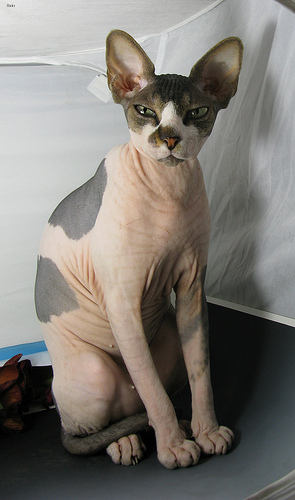

In [10]:
from random import randint
fst.PILImage.create(files[randint(0,7390)])

Voltando para a variável `files`, perceba que as imagens de gatos estão salvas em arquivos cujos nomes se iniciam com letra maiúscula, ao passo que as imagens de cães estão em arquivos cujos nomes se iniciam com letra minúscula.

Isso foi feito para que fosse possível diferenciar as imagens apenas pelo nome do arquivo, pois é essa diferenciação que será utilizada para produzir as labels de cada imagem. A função `is_cat()`, criada na célula abaixo, retorna um booleano que indica se a primeira letra da variável de entrada é maiúscula (nesse caso, `True`) ou minúscula (`False`).

In [11]:
def is_cat(x): return x[0].isupper()

Para finalizar o processamento dos nossos dados, nós criaremos um Dataloader utilizando a função `fst.ImageDataLoaders.from_name_func()` da biblioteca do *fastai2*. Os parâmetros da função são:

- `path`: indica o diretório em que o algoritmo deve trabalhar.
- `fnames`: recebe a lista com os diretórios e nomes de todas as imagens que serão incorporadas ao DataLoader.
- `valid_pct`: determina o tamanho do dataset de validação (nesse caso, valid_pct=0.2, significa que 20% do dataset será destinado à validação).
- `seed`: escolhe um número qualquer para garantir a reprodução do exercício com os mesmos resultados.
- `label_func`: especifica a função que identificará o label de cada exemplo do dataset, no nosso caso, a função `is_cat()` definida na célula acima.
- `item_tfms`: aponta quais serão as transformações aplicadas em cada imagem do dataset, a mais comum delas é o redimensionamento (*resize*).


In [12]:
# Load data into fastai
dls = fst.ImageDataLoaders.from_name_func(   # Structure of dataset
          path=path,                         # Working directory
          fnames= files,                     # List of files
          valid_pct=0.2,                     # Size of validation set
          seed=42,                           # Random number seed
          label_func=is_cat,                 # Helper function for labels
          item_tfms= fst.Resize(224))        # Data transformations

Como citado acima, o parâmetro `seed` funciona para garantir a reprodutibilidade de um processo randômico, mas como isso funciona?

De fato, os algoritmos não conseguem produzir processos realmente randômicos e sim os chamados processos pseudo-randômicos. Esses processos são funções matemáticas que se utilizam de outras variáveis (geralmente o horário) para produzir sequências que parecem randômicas. A definição de um valor para o parâmetro `seed` faz com que essa variável utilizada seja o valor indicado, de forma que a sequência de valores gerada sempre será a mesma.

Para ter mais informações sobre a geração de números randômicos, [clique no link](https://machinelearningmastery.com/how-to-generate-random-numbers-in-python/).

### 1.3 Criação e treinamento da Rede Neural

Com todo o dataset processado, podemos criar a nossa rede neural. Para isso, utilizaremos a técnica de *transfer learning*, utilizando uma ResNet, uma rede neural residual pré-treinada. Para mais informações sobre essas redes neurais, [clique no link](https://arxiv.org/pdf/1512.03385.pdf).

In [13]:
# Create a fastai "learner"
learn = fst.cnn_learner(     # Helper function to create learner for CNNs
    dls=dls,                 # Previously created dataloaders
    arch=fst.resnet34)       # Pretrained model architecture

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 170MB/s]


Com a ResNet34 e o dataloader `dls` selecionados, podemos iniciar o treinamento da nossa rede neural. Para isso, utilizaremos a função `fine_tune()` com o número de épocas escolhido. Como o dataset é relativamente grande e a rede ja é pré-treinada, não precisaremos de muitas épocas e, por isso, escolhemos treinar a nossa rede por apenas 3 épocas.

In [14]:
epochs = 3

# Train the model (fine-tuning)
learn.fine_tune(3)

epoch,train_loss,valid_loss,time
0,0.187712,0.025672,00:57


epoch,train_loss,valid_loss,time
0,0.047251,0.047751,00:56
1,0.034423,0.006140,00:56
2,0.022475,0.004537,00:55


Para saber mais sobre *finetuning* no contexto de *Transfer Learning*, [clique neste link](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html).

Para ter mais informações sobre a função `fine_tune()`, execute a célula abaixo.

In [15]:
?learn.fine_tune


### 1.4 Teste da Rede neural

Agora nós testaremos a nossa rede treinada. Para isso, utilizaremos a biblioteca `ipywidgets` que nos permitirá fazer o upload de qualquer imagem salva em nossos computadores.

Escolha duas imagem de sua preferência, uma que contenha um gato nela e outra que contenha um cão e faça o teste. Se você não possuir as imagens já salvas, recomendamos que faça o dowload através do Google.

Execute a célula abaixo para gerar um campo onde você poderá fazer o upload de imagens que serão utilizadas para testar a nossa rede neural. Neste primeiro momento, faça o upload de uma figura de um gato.

In [16]:
#Test with cat
from ipywidgets import widgets
uploader1 = widgets.FileUpload()
print('Faça o upload de uma imagem que contenha um gato')
uploader1

Faça o upload de uma imagem que contenha um gato


FileUpload(value={}, description='Upload')

Com o upload feito, podemos visualizar a imagem para, em seguida, utilizá-la como entrada da rede neural.

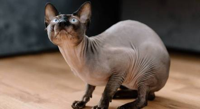

In [17]:
img1 = fst.PILImage.create(uploader1.data[0])
img1.to_thumb(200)

In [18]:
is_cat,_,probs = learn.predict(img1)
print(f"Isso é um gato?: {is_cat}.")
print(f"Probabilidade de ser um gato: {100* probs[1].item():.6f}%")

Isso é um gato?: True.
Probabilidade de ser um gato: 100.000000%


Faremos, agora, o mesmo processo, mas com uma imagem de um cão.

In [19]:
uploader2 = widgets.FileUpload()
print('Faça o upload de uma imagem que contenha um cão')
uploader2

Faça o upload de uma imagem que contenha um cão


FileUpload(value={}, description='Upload')

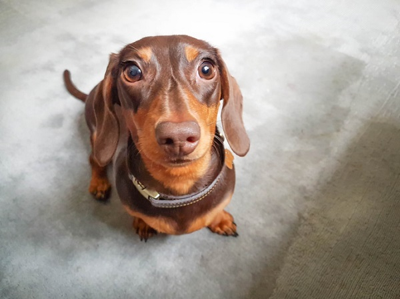

In [20]:
img2 = fst.PILImage.create(uploader2.data[0])
img2.to_thumb(400)

In [21]:
is_cat,_,probs = learn.predict(img2)
print(f"Isso é um gato?: {is_cat}.")
print(f"Probabilidade de ser um gato: {100* probs[1].item():.6f}%")

Isso é um gato?: False.
Probabilidade de ser um gato: 0.004310%


Temos então uma rede neural treinada para distinguir imagens de cachorros de imagens de gatos com acurácia significativamente alta. Essa é uma das aplicações mais conhecidas do que chamamos "visão computacional".

O modelo de aprendizagem de máquina adotado nesse exercício é chamado de *Transfer Learning*, e é altamente poderoso. Consiste, basicamente, em tomar uma rede neural pré-treinada (nesse caso a ResNet34) e treiná-la novamente para executar uma função específica (nesse caso distinguir imagens de cachorros de imagens de gatos) a partir de um novo dataset (nesse caso as 7390 imagens de cachorros e gatos fornecidas).

O nosso intuito, ao apresentar esse exercício, é de oferecer uma nova ferramenta para aplicações diversas. Convidamos você a modificar os parâmetros originais desse notebook (como o número de épocas, o tamanho do set de validação, etc) para visualizar as consequências de cada alteração.

Posteriormente, é possível também fornecer um novo dataset para treinar a rede para executar uma nova função, tal como distinguir baleias de golfinhos, motos de carros, raios-x de ossos quebrados de intactos etc.

## 2 CNN para classificação binária de imagens

Imersos agora no problema de distinção entre raças de cachorros, implementaremos outra rede neural convolucional para identificação de duas raças de cães, utilizando agora a biblioteca Pytorch. Essa biblioteca já lhes foi apresentada no Desafio de Programação 3, e agora será explorada de maneira mais profunda.

Usaremos os seguintes módulos necessários para a **construção** da rede neural, lembrando que eles já foram importados no início do Jupyter Notebook.

*   A biblioteca `torch`;
*   `transforms` do módulo `torchvision.transforms`;
*   `ImageFolder` do módulo `torchvision.datasets`;
*   `DataLoader` e `random_split` do módulo `torch.utils.data`.

Além do Pytorch, repare que também importamos alguns elementos da biblioteca torchvision. De fato, apesar de a sua importação ser feita separadamente, o torchvision faz parte do Pytorch e nada mais é do que uma biblioteca que nos permite importar modelos pré-treinados e datasets clássicos já montados além de disponibilizar ferramentas que ajudarão a estruturar os dados que serão utilizados na rede neural em questão. Nesta atividade, utilizaremos o torchvision apenas para organizar os nossos dados que serão inseridos na rede neural que também criaremos.

### 2.1 Processamento do dataset

Os dados que serão utilizados já estão baixados na pasta "Data" e serão, na célula abaixo, importados para dentro da variável data.

In [30]:
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
#data = ImageFolder('/content/drive/MyDrive/Desafios de programacao - TopEng 2_2023/Desafio de programação 5/Utilidades-DP5/Data/Duas', transform=transform)
data = ImageFolder('/content/drive/MyDrive/TopEng/DP5/Utilidades-DP5/Data/Duas', transform=transform)

A primeira linha da célula acima define a variável `transform` utilizando a função `transforms.Compose`, que executa uma composição de todas as transformações que estão dentro da lista que é passada como seu único parâmetro. Nesse caso, as duas únicas transformações são o remodelamento do tamanho da imagem para 224 pixels (`transforms.Resize(224)`) e a transformação dessa imagem para um tensor (`transforms.ToTensor()`). Ressaltamos que o número 224 foi apenas um padrão adotado, mas outros valores também são válidos. Para ter acesso a outras transformações disponibilizadas por essa biblioteca, [clique neste link](https://pytorch.org/docs/stable/torchvision/transforms.html).

Na sequência, nós utilizamos a função `ImageFolder` para coletar as imagens que estão dentro do diretório passado como parâmetro, salvando-as em um dataset. Para que essa função funcione, devemos separar os nossos exemplos em pastas cujos nomes serão utilizados como as labels das imagens presentes dentro de suas respectivas pastas.

É recomendável que o aluno abra a pasta "Data" e veja como há essa distinção exatamente no diretório passado como parâmetro da função `ImageFolder`.

A partir da importação do dataset, podemos visualizar o tamanho do dataset.

Faremos agora a divisão entre o dataset de treino e o de teste. A divisão, inicialmente, será feita da seguinte forma:
- Dataset de treino: será contituído por aproximadamente 75% dos dados.
- Dataset de teste: será constituído pelo restante dos dados.

Para efetuar a divisão, utilizaremos a função `random_split()`. Repare que garantiremos a reprodutibilidade usando a mesma técnica que foi utilizada na seção 1.2 desta tarefa, especificando um valor de `seed` (nesse caso, 42).

In [50]:
print('Total de imagens no dataset:', len(data))
percentage = 75
n_treino = round(len(data)* (percentage/100))
n_teste = round(len(data)* (100 - percentage)/(2*100))
n_valid = len(data) - n_treino - n_teste

print('nº de imagens para treino: {:}'.format(n_treino) +'; nº de imagens para teste: {:}'.format(n_teste) +'; nº de imagens para validação: {:}'.format(n_valid) + '.')
data_train, data_test, data_valid = random_split(data, [n_treino, n_teste, n_valid], generator=torch.Generator().manual_seed(42))

batch_size = 20
loader_train, loader_test, loader_valid = DataLoader(data_train, batch_size=batch_size), DataLoader(data_test, batch_size=1), DataLoader(data_valid, batch_size=1)

Total de imagens no dataset: 407
nº de imagens para treino: 305; nº de imagens para teste: 51; nº de imagens para validação: 51.


Repare que nós utilizamos a função `round()` para evitar que a multiplicação resulte em um número não inteiro, arredondando, assim, para o número inteiro mais próximo.

Veja, também, a criação dos *dataloaders* de treino e de teste utilizando a função `Dataloader`. Isso é importante para que consigamos combinar exemplos e labels em iterações, além de dividir os dados de treinamento em *batches*.

Escolhemos o valor inicial de *batch_size* de 20, mas a escolha deste valor não é rígida e não há uma fórmula pronta para isso. Por isso, assim que finalizarmos a nossa rede neural, recomendamos que você modifique o valor desse parâmetro e veja quais são as mudanças que acontecem no processo de treinamento e de teste.

### 2.2 Montando uma Rede Neural com Pytorch

Montaremos agora a rede neural que será utilizada para a classificação. A estruturação da rede será da seguinte forma:

#### *Input Layer*

- Uma camada:
  - Camada com 3 canais de entrada, de 224x224 cada.

#### *Feature Mapping Layers*

- Três conjuntos de convolução/*pooling*, totalizando seis camadas; Todas as camadas terão filtro iguais:
  - **Filtro convolucional:** *kernel size* de 4x4, *stride* igual a 2 e *padding* igual a 1.
  - **Filtro de *pooling*:** *kernel size* de 2x2 e *stride* igual a 2.

- Primeiro conjunto:
  - A primeira camada de convolução deve ter 3 canais de entrada e 8 de saída, resultando em 8 canais de dimensão 112x112;
  - A primeira camada de *pooling* reduzirá a dimensão de cada canal para 56x56;
    
- Segundo conjunto:
  -  A segunda camada de convolução deve ter 8 canais de entrada e 16 de saída, resultando em 16 canais de dimensão 28x28;
  - A segunda camada de *pooling* reduzirá a dimensão de cada canal para 16x16;
   
- Terceiro conjunto:
  -  A terceira camada de convolução deve ter 16 canais de entrada e 32 de saída, resultando em 32 canais de dimensão 8x8;
  - A terceira camada de *pooling* reduzirá a dimensão de cada canal para 4x4;
  
#### *Fully Connected Layers*

- Três camadas:
  - A primeira camada deve ter 512 *hidden units*;
  - A segunda camada deve ter 128 *hidden units*.
  - A terceira camada deve ter 16 *hidden units*.

#### *Output Layer*

- Uma camada:
  - Camada com 2 *outputs*


A arquitetura acima está ilustrada no esquemático abaixo:

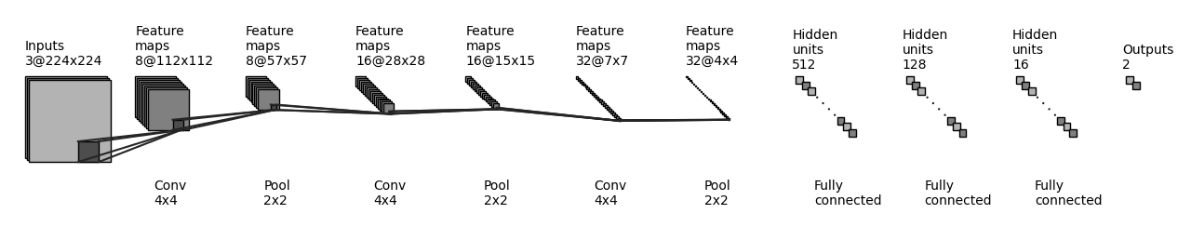

Agora, você deve completar o código abaixo para construir a rede neural mostrada e detalhada acima. Nós já fornecemos todos os parâmetros dos filtros de convolução e de *pooling* nas primeiras linhas do código. Além disso, nós também já construímos o primeiro conjunto de camadas para que sirva de exemplo. Por fim, as camadas *fully connected* também já estão implementadas ao final do código. Agora, cabe a você escrever os outros dois conjuntos de camadas da rede neural convolucional.

Atente-se ao número de canais em cada camada da rede neural e que cada um desses conjuntos de camadas devem estar guardados dentro das variáveis `self.layer2` e `self.layer3`. A correta implementação desta classe lhe agregará **10 pontos** dentro da pontuação total deste desafio de programação.

In [51]:
class NN_CNN(torch.nn.Module):
	def __init__(self, altura_imagem, largura_imagem, n_layer=3):
		super(NN_CNN, self).__init__()
		self.kernel_size_conv = 4
		self.stride_conv = 2
		self.padding_conv = 1
		self.dilation_conv = 1

		self.kernel_size_pool = 2
		self.stride_pool = 2
		self.padding_pool = 1
		self.dilation_pool = 1

		self.altura_imagem = altura_imagem
		self.largura_imagem = largura_imagem

		self.layer1 = torch.nn.Sequential(
      torch.nn.Conv2d(
          in_channels=3,
          out_channels=8,
          kernel_size=self.kernel_size_conv,
          stride=self.stride_conv,
          padding=self.padding_conv,
          dilation=self.dilation_conv),
          torch.nn.ReLU(),
          torch.nn.MaxPool2d(
              kernel_size=self.kernel_size_pool,
              stride=self.stride_pool,
              padding=self.padding_pool,
              dilation=self.dilation_pool)
          )


		"""
    Estruture a arquitetura da rede convolucional, tomando por base a definição
		da primeira camada, que foi fornecida acima. A rede criada deve ter a
		mesma arquitetura da rede solicitada para que seja considerada correta.

    Instruções
    ------------
    Siga o exemplo da implementação da primeira camada para implementar as
		demais. Atente-se à compatibilidade entre camadas vizinhas, tal que o
		número de canais de saída da anterior seja compatível com o número de
		canais de entrada da seguinte. Você deve ter por objetivo a arquitetura
		exigida, sendo ela a única válida para pontuar na questão.

		Nota
		------------
		Você é livre para modificar os parâmetros da rede (Convolução, Função
		de Ativação e Pooling) desde que implemente a arquitetura pedida. No
		entanto, recomendamos que utilize os mesmos parâmetros definidos para a
		primeira camada, por simplicidade.

    """

		self.layer2 = 0
		self.layer3 = 0


#======================== YOUR CODE HERE ==========================

		self.layer2 = torch.nn.Sequential(
      torch.nn.Conv2d(
          in_channels=8,
          out_channels=16,
          kernel_size=self.kernel_size_conv,
          stride=self.stride_conv,
          padding=self.padding_conv,
          dilation=self.dilation_conv),
          torch.nn.ReLU(),
          torch.nn.MaxPool2d(
              kernel_size=self.kernel_size_pool,
              stride=self.stride_pool,
              padding=self.padding_pool,
              dilation=self.dilation_pool)
          )

		self.layer3 = torch.nn.Sequential(
      torch.nn.Conv2d(
          in_channels=16,
          out_channels=32,
          kernel_size=self.kernel_size_conv,
          stride=self.stride_conv,
          padding=self.padding_conv,
          dilation=self.dilation_conv),
          torch.nn.ReLU(),
          torch.nn.MaxPool2d(
              kernel_size=self.kernel_size_pool,
              stride=self.stride_pool,
              padding=self.padding_pool,
              dilation=self.dilation_pool)
          )

    #=================================================================


		self.dicio = {}
		self.dicio[0] = self.layer1
		self.dicio[1] = self.layer2
		self.dicio[2] = self.layer3

		self.size_list = [(altura_imagem, largura_imagem)]
		self.num_list, self.patch_size_list = [], []
		altura, largura = altura_imagem, largura_imagem
		for n in range(n_layer):
			self.conv_altura = 1 + (altura + 2*self.padding_conv - self.dilation_conv*(self.kernel_size_conv - 1) - 1)//self.stride_conv
			self.conv_largura = 1 + (largura + 2*self.padding_conv - self.dilation_conv*(self.kernel_size_conv - 1) - 1)//self.stride_conv
			altura = 1 + (self.conv_altura + 2*self.padding_pool - self.dilation_pool*(self.kernel_size_pool - 1) - 1)//self.stride_pool
			largura = 1 + (self.conv_largura + 2*self.padding_pool - self.dilation_pool*(self.kernel_size_pool - 1) - 1)//self.stride_pool

			self.size_list.append((self.conv_largura, self.conv_altura))
			self.num_list.append(self.dicio[n][0].in_channels)
			self.size_list.append((altura, largura))
			self.num_list.append(self.dicio[n][0].out_channels)
			self.patch_size_list.append((self.kernel_size_conv,self.kernel_size_conv))
			self.patch_size_list.append((self.kernel_size_pool, self.kernel_size_pool))

		self.num_list.append(self.num_list[-1])

		self.fc1 = torch.nn.Linear(512,128)
		self.fc2 = torch.nn.Linear(128,16)
		self.fc3 = torch.nn.Linear(16,2)

		self.num_fc_list = []
		self.num_fc_list.append(self.fc1.in_features)
		self.num_fc_list.append(self.fc2.in_features)
		self.num_fc_list.append(self.fc3.in_features)
		self.num_fc_list.append(self.fc3.out_features)

Com a estrutura da nossa rede neural montada, iremos utilizar a função `cria_imagem()` disponibilizada no arquivo `utils` para produzir uma imagem com o layout da rede neural construída na célula acima. Se a estrutura vista na imagem for diferente daquela mostrada acima, é provável que haja algum erro na implementação da célula superior.

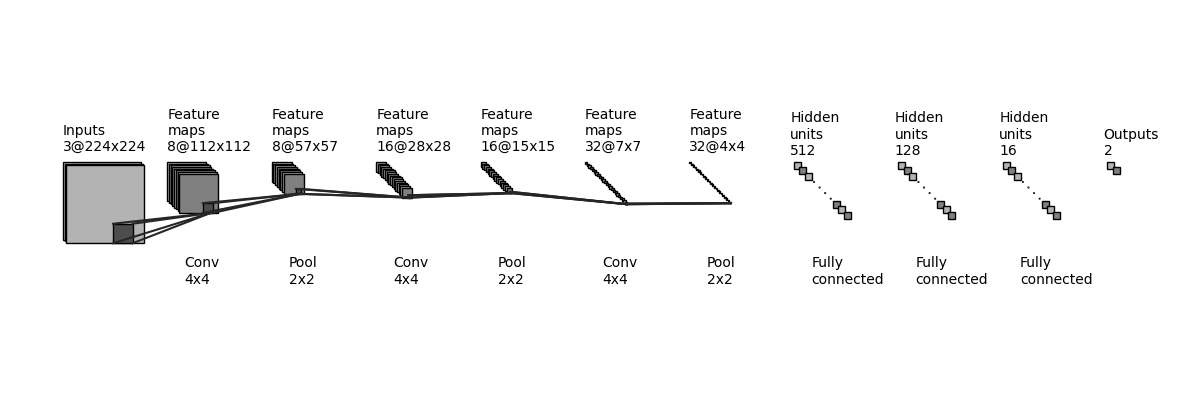

NN_CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

In [52]:
model = NN_CNN(224,224)
utils.cria_imagem(model)
model

Com a rede construída, devemos implementar a função `forward()` que receberá como entrada uma imagem de 3 canais de 224x224 de dimensão cada uma e passará essa figura pelos 3 conjuntos de camadas da rede neural e, depois disso, passará o resultado através das três camadas *fully connected*. Esse resultado deve ser salvo na variável `out`, que é retornada ao final da função.

Repare que na Tarefa de Programação 3 nós utilizamos uma função similar que você pode utilizar como inspiração para implementar esta. A correta implementação desta função lhe agregará **10 pontos** dentro da pontuação total deste desafio de programação.



In [53]:
def forward(self,x):
    """
    Implemente a propagação direta na rede neural para que, dado um conjunto de
    dados de entrada "x", o modelo possa prever a probabilidade de pertencer a
    cada uma das classes de saída "^y".

    Parâmetros
    ----------
    self : class_like
      Class que contém os parâmetros da rede.

    x: array_like
        Dataset de entrada. Um vetor com shape (1 x 224*224).

    Retorna
    --------
    out : array_like
        Saída da rede. Vetor com as probabilidades da entrada pertencer a cada
        uma das classes.

    Instruções
    ------------
    Propague os dados de entrada camada a camada, até a camada de saída.
    Atente-se à arquitetura da rede.

    """
    out = 0
    #======================== YOUR CODE HERE ==========================

    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = torch.flatten(out, 1)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)

    #==================================================================

    return out

Com a função pronta, iremos instanciar a rede neural na variável `model` através da execução da célula abaixo e adicionar a função `forward` nela utilizando a função `types.MethodType()`.

In [55]:
model = NN_CNN(altura_imagem=224,largura_imagem=224).to(device)

import types
model.forward = types.MethodType(forward,model)

Com a rede neural configurada corretamente e a função `forward()` implementada de maneira adequada, poderemos efetuar o treinamento e o teste da nossa função.

Repare que a variável model que foi carregada na célula acima não é carregada novamente na célula abaixo. Isso faz com que as variáveis utilizadas na célula abaixo não sejam recarregadas a cada vez que a célula for executada, permitindo que o mesmo modelo possa ser treinado e testado por mais épocas, partindo do ponto que havia parado. Se você pretender reiniciar o processo, treinando um modelo desde o início, reiniciando a vairável `model`, execute a célula acima.

In [56]:
epochs = 30 #default = 30
lr = 0.0025 #default = 0.0025

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

list_train_loss = []
list_test_loss = []
list_acc = []
for epoch in range(1, epochs+1):
	model.train()
	for imagem_treino,label_treino in loader_train:
		imagem_treino, label_treino = imagem_treino.float().to(device), label_treino.to(device)
		outputs = model(imagem_treino)
		outputs = (torch.log_softmax(outputs,dim=1))
		loss = criterion(outputs, label_treino.float().long())

		optimizer.zero_grad() #Zera o gradiente para que ele não seja constantemente acumulado na backpropragation que vem a seguir
		loss.backward() #Realiza a backpropragation
		optimizer.step() #realiza mais um passo dentro do gradiente
	list_train_loss.append(loss.item()) #Guarda o valor da função de perda

	correct = 0
	total = 0
	model.eval()
	for imagem_teste, label_teste in loader_test:
		imagem_teste, label_teste = imagem_teste.float().to(device), label_teste.to(device)
		outputs_test = model(imagem_teste)
		outputs_test = (torch.log_softmax(outputs_test,dim=1))
		_,previsao = torch.max(outputs_test, dim = 1)
		loss_test = criterion(outputs_test, label_teste.long())
		total = total + 1 #Adiciona +1 na variável que guarda o total de previsões feitas
		if previsao == label_teste:
			correct = correct + 1 #Soma +1 na variável que mede quantas previsões dessa categoria (erro absoluto de 2 graus) estão certas
	list_test_loss.append(loss_test.item())

	acc = (correct/total)*100 #Calcula a acurácia para erro absoluto de 1 grau em porcentagem
	list_acc.append(acc) #Adiciona essa acurácia a sua lista


	print('epoch:', epoch ,' loss: {:.4f}'.format(loss.item()), ' Accuracy: {:.2f}'.format(acc)) #Printa o valor da função de erro, o sMAPE e a acurácia a cada época


epoch: 1  loss: 0.6658  Accuracy: 39.22
epoch: 2  loss: 0.6731  Accuracy: 39.22
epoch: 3  loss: 0.6753  Accuracy: 39.22
epoch: 4  loss: 0.6741  Accuracy: 39.22
epoch: 5  loss: 0.6748  Accuracy: 41.18
epoch: 6  loss: 0.6637  Accuracy: 54.90
epoch: 7  loss: 0.5169  Accuracy: 47.06
epoch: 8  loss: 0.5921  Accuracy: 56.86
epoch: 9  loss: 0.4542  Accuracy: 60.78
epoch: 10  loss: 0.5403  Accuracy: 50.98
epoch: 11  loss: 0.3711  Accuracy: 56.86
epoch: 12  loss: 0.1619  Accuracy: 68.63
epoch: 13  loss: 0.1175  Accuracy: 78.43
epoch: 14  loss: 0.0414  Accuracy: 80.39
epoch: 15  loss: 0.0467  Accuracy: 74.51
epoch: 16  loss: 0.0173  Accuracy: 78.43
epoch: 17  loss: 0.0057  Accuracy: 74.51
epoch: 18  loss: 0.0084  Accuracy: 72.55
epoch: 19  loss: 0.0006  Accuracy: 70.59
epoch: 20  loss: 0.0053  Accuracy: 76.47
epoch: 21  loss: 0.0003  Accuracy: 70.59
epoch: 22  loss: 0.0003  Accuracy: 76.47
epoch: 23  loss: 0.0021  Accuracy: 72.55
epoch: 24  loss: 0.0069  Accuracy: 76.47
epoch: 25  loss: 0.0741  

A partir do treinamento e do teste do nosso modelo, podemos analisar o comportamento do custo e da acurácia ao longo das épocas.

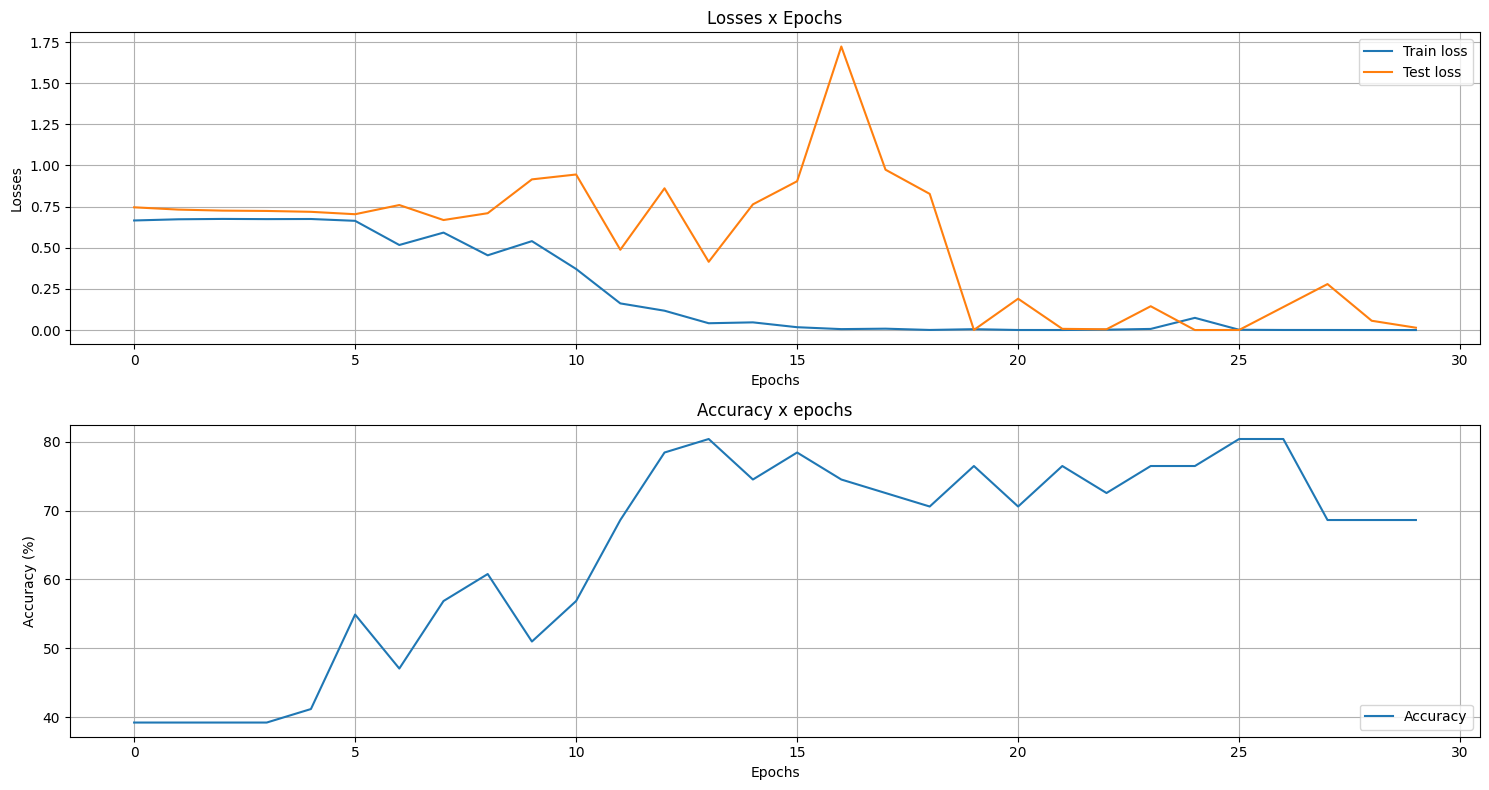

In [57]:
fig, axs = pyplot.subplots(2,figsize=(15,8))
axs[0].plot(list_train_loss,label="Train loss") #Plota o erro de treino X epocas
axs[0].plot(list_test_loss, label="Test loss") #Plota o erro de teste x epocas
axs[0].set_title('Losses x Epochs') #Define o título
axs[0].set(xlabel='Epochs') #Define o nome do eixo x
axs[0].set(ylabel='Losses') #Define o nome do eixo y
axs[0].legend() #Mostra a legenda
axs[0].grid(True) #Mostra a grade


axs[1].plot(list_acc, label='Accuracy') #Plota a acuracia para erro x epocas
axs[1].set_title('Accuracy x epochs') #Define o título
axs[1].set(xlabel='Epochs') #Define o nome do eixo x
axs[1].set(ylabel='Accuracy (%)') #Define o nome do eixo y
axs[1].legend(loc='lower right') #Mostra a legenda
axs[1].grid(True) #Mostra a grade

pyplot.tight_layout()


Sugere-se que o aluno modifique os parâmetros utilizados no treinamento da rede. Os valores a serem testados são os seguintes (nessa ordem):

  a)  *Batch Size* (variável `batch_size`): [10, 50, 100, 500];

  b) Porcentagem *Training_Set*/*Full_dataset* (variável `percentage`): [70, 80, 90].

  c)  *Learning Rate* (variável `lr`): [0.0005, 0.001, 0.005, 0.01, 0.05];

  d) *Epochs* (variável `epochs`): [5, 20, 40, 60].

Para isso, pedimos que siga as seguintes instruções:

1. Modifique apenas um dos parâmetros sob teste, deixando os demais com seus valores *defaults*.

2. Atribua os valores pedidos ao parâmetro sob teste, respeitando a ordem designada.

3. Execute novamente todas as célula a partir daquela que sofreu a alteração, com o valor do parâmetro sob teste modificado. Lembre-se de reiniciar a sua variável `model`.

4. Observe as diferenças no tempo de execução e na acurácia obtida.

5. Repita o procedimento com o próximo valor (ou o próximo parâmetro) a ser testado.

6. Ao finalizar todos os testes, atribua os valores *default* novamente aos parâmetros modificados.


### 2.3 Importando uma rede pré-treinada

Na atividade anterior nós implementamos uma CNN que conseguia distinguir imagens de raças de cães. Agora, nós iremos nos debruçar sobre o mesmo problema, mas faremos isso com outras ferramentas.

Na tarefa anterior nós criamos inteiramente a estrutura da CNN. Agora, nós utilizaremos o conceito de Transfer Learning, importando a Rede Neural pré treinada ResNet18 para fazer a classificação em questão.

O intuito é compararmos os ganhos e as perdas que esta técnica nos traz na resolução deste problema.

Com os dados carregados na variável `data`, da atividade anterior, dividiremos o dataset em porções para treino e para teste.

Dica: se necessário, execute novamente a célula de importação do dataset do exercício anterior:

    transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
    data = ImageFolder('/content/drive/MyDrive/Desafios de programacao - TopEng 2_2023/Desafio de programação 5/Utilidades-DP5/Data', transform=transform)

Diferentemente do que foi feito na última tarefa, nós não criaremos o nosso modelo de rede neural. Dessa vez, nós importaremos um modelo pré treinado, nesse caso, o escolhido foi a `ResNet18` por conta da sua simplicidade e eficiência.

Para isso, utilizaremos o módulo `models` da biblioteca `torchvision` ao executar a célula abaixo. Esse módulo disponibiliza várias redes neurais pré treinadas de diferentes tipos. Para acessar a lista completa, [clique neste link](https://pytorch.org/docs/stable/torchvision/models.html).

Como dito, a escolhida foi uma ResNet, mais especificamente a `Resnet18`. Dentre todas as ResNet's disponíveis, esta é a que possui estrutura mais simples, e, por isso, é a que demanda menos memória e tempo para treinamento e teste. Para mais detalhes sobre essas redes, [clique neste link](https://arxiv.org/pdf/1512.03385.pdf).

In [33]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


Para ver a estrutura da rede escolhida, execute a célula abaixo.

In [34]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

O *Transfer Learning* é uma técnica que nos permite utilizar uma rede cujos parâmetros já foram treinados utilizando datasets grandes e diversos. Porém, a estrutura da rede nem sempre se encaixa ao contexto em que vamos utilizar. Por exemplo, a camada de *output* da ResNet18 possui mil unidades mas, para o nosso problema, nós precisamos apenas de duas unidades de saída.

Para resolver isso, nós podemos modificar as camadas da rede conforme desejamos. Para esse exemplo, nós estamos interessados em modificar apenas as últimas camadas da rede, chamadas *fully connected layers* (ou `fc`).

Antes de fazer qualquer modificação na arquitetura na rede, nós podemos desativar a funcionalidade do Pytorch que calcula automaticamente os gradientes dos parâmetros da rede. Faremos isso porque não desejamos atualizar os parâmetros da parte convolucional da rede, pois eles serão "congelados" para essa aplicação. Isso não é estritamente necessário, mas diminui o custo computacional do algoritmo e nos poupa bastante tempo.

Obs: como mudamos as últimas camadas da rede **depois** de desativar o cálculo do gradiente para os parâmetros da rede, os novos parâmetros entram com o cálculo do gradiente ativados por *default* do Pytorch, possibilitando que os treinemos em seguida.

In [35]:
# Freeze our model parameters
for param in model.parameters():
  param.requires_grad = False

# Change the architecture of the classifier portion of the CNN
classifier = nn.Sequential(nn.Linear(512,128),
                           nn.ReLU(),
                           nn.Dropout(p=0.2),
                           nn.Linear(128,2),
                           nn.LogSoftmax(dim=1))

model.fc = classifier

Conforme explicado, nós alteramos somente a porção fully connected da rede, a qual é responsável pela classificação dos exemplos. As camadas convolucionais, que são responsáveis pela extração de características (feature extraction) das entradas foram deixadas "congeladas".

Para visualizar a nova arquitetura da rede, execute a célula abaixo.

In [36]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Definimos, então, alguns parâmetros importantes para o treinamento da rede, e inicializamos algumas variáveis que usaremos durante o treinamento.

Esses parâmetros foram escolhidos após alguns testes que fizemos e foram os que ofereceram melhores resultados no treino da rede. Esse procedimento deve ser repetido pelo aluno na segunda parte deste notebook.

In [37]:
epochs = 5
lr = 0.001

criterion = nn.NLLLoss()

optimizer = torch.optim.AdamW(model.fc.parameters(), lr=lr)

list_train_loss = []
list_test_loss = []
list_acc = []

model = model.to(device)

Nota-se que escolhemos como otimizador o algoritmo *Adaptive Moment Estimation with Decoupled Weight Decay* (AdamW, da sigla em inglês). Esse otimizador é uma alternativa ao clássico *Gradient Descent*, só que muito mais robusto e eficaz (na maioria dos casos), pois implementa técnicas como momentum e RMSprop. Para saber mais sobre ele, execute a célula abaixo e acesse os links indicados.

In [38]:
?torch.optim.AdamW

Passamos então para o treinamento e teste da rede.

Obs: a primeira vez que rodamos a célula abaixo tende a demorar muito mais do que o esperado. Por isso, sugere-se que caso após um minuto de execução não apareça nenhum print no formato "Epoch:  X  loss: X.XXXX  Accuracy: XX.XX  Time spent this epoch: XX.XX seconds" (ou mensagem de erro), o aluno interrompa e reinicie a execução da célula.

In [39]:
START = time.time()

for epoch in range(1, epochs+1):
	start = time.time()

	# Etapa de Treino
	model.train()
	loss_train = 0

	for imagem_treino,label_treino in loader_train:

		loss = 0

		imagem_treino, label_treino = imagem_treino.float().to(device), label_treino.to(device)
		outputs = model(imagem_treino)
		loss = criterion(outputs, label_treino.float().long())

		optimizer.zero_grad() #Zera o gradiente para que ele não seja constantemente acumulado na backpropragation que vem a seguir
		loss.backward() #Realiza a backpropragation
		optimizer.step() #realiza mais um passo dentro do gradiente
		loss_train += loss

	loss_train = loss_train/len(loader_train)
	list_train_loss.append(loss_train.item()) #Guarda o valor da função de perda

	# Etapa de Teste
	model.eval()
	correct = 0
	total = 0
	loss_test = 0

	with torch.no_grad():
		for imagem_teste, label_teste in loader_test:

			imagem_teste, label_teste = imagem_teste.float().to(device), label_teste.to(device)
			outputs_test = model(imagem_teste)

			_,previsao = torch.max(outputs_test, dim = 1)
			loss_test += criterion(outputs_test, label_teste.long())
			total = total + 1 #Adiciona +1 na variável que guarda o total de previsões feitas

			if previsao == label_teste:
				correct = correct + 1 #Soma +1 na variável que mede quantas previsões dessa categoria (erro absoluto de 2 graus) estão certas

		loss_test = loss_test/len(loader_test)
		list_test_loss.append(loss_test.item())

	acc = (correct/total)*100 #Calcula a acurácia para erro absoluto de 1 grau em porcentagem
	list_acc.append(acc) #Adiciona essa acurácia a sua lista

	end = time.time()
	Time = end - start

	if epoch < 10:
		print('Epoch: ', epoch ,' loss: {:.4f}'.format(loss_test.item()), ' Accuracy: {:.2f}'.format(acc), ' Time spent this epoch: {:.2f}'.format(Time), 'seconds.')
	else:
		print('Epoch:', epoch ,' loss: {:.4f}'.format(loss_test.item()), ' Accuracy: {:.2f}'.format(acc), ' Time spent this epoch: {:.2f}'.format(Time), 'seconds.')

END = time.time()

print()
TIME = END - START
print('\n Time spent during training: {:.2f}'.format(TIME), 'seconds')

Epoch:  1  loss: 0.0867  Accuracy: 100.00  Time spent this epoch: 2.44 seconds.
Epoch:  2  loss: 0.0244  Accuracy: 100.00  Time spent this epoch: 3.09 seconds.
Epoch:  3  loss: 0.0166  Accuracy: 100.00  Time spent this epoch: 3.05 seconds.
Epoch:  4  loss: 0.0049  Accuracy: 100.00  Time spent this epoch: 2.38 seconds.
Epoch:  5  loss: 0.0044  Accuracy: 100.00  Time spent this epoch: 2.41 seconds.


 Time spent during training: 13.39 seconds


Concluído o treinamento, passamos então à análise dos resultados.

A célula abaixo plota as curvas dos erros de treino e de teste por época. Uma boa análise dessas curvas pode nos dar informações sobre a adequação do modelo ao problema proposto: *overfitting*, *underfitting* ou adequado.

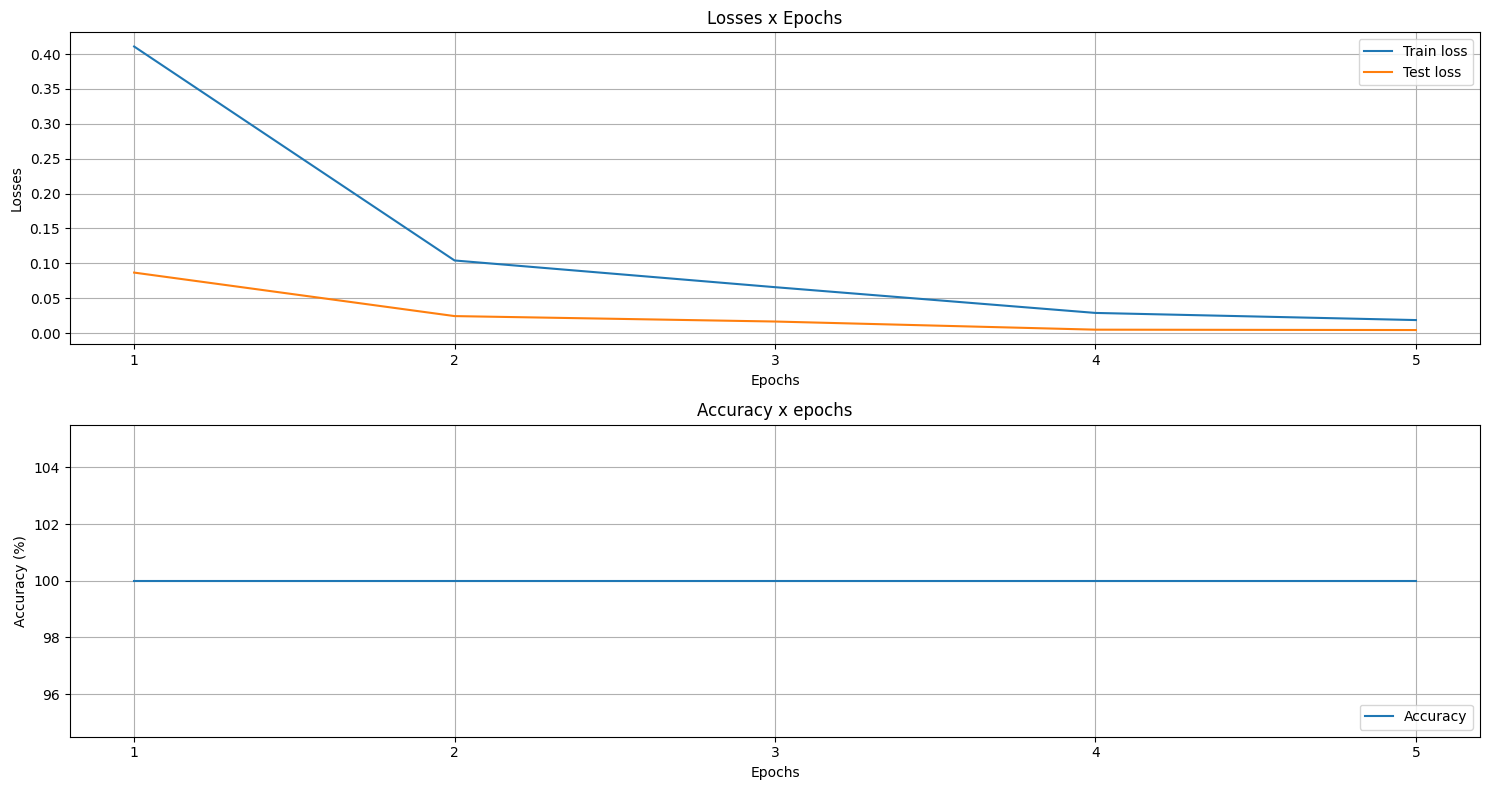

In [40]:
fig, axs = pyplot.subplots(2, figsize=(15,8))
axs[0].plot(range(1, epochs+1,1), list_train_loss[:epochs],label="Train loss") #Plota o erro de treino X epocas
axs[0].plot(range(1, epochs+1,1), list_test_loss, label="Test loss") #Plota o erro de teste x epocas
axs[0].set(xticks=range(1, epochs+1,1))
axs[0].set_title('Losses x Epochs') #Define o título
axs[0].set(xlabel='Epochs') #Define o nome do eixo x
axs[0].set(ylabel='Losses') #Define o nome do eixo y
axs[0].legend() #Mostra a legenda
axs[0].grid(True) #Mostra a grade


axs[1].plot(range(1, epochs+1,1), list_acc, label='Accuracy') #Plota a acuracia para erro de 1 graus x epocas
axs[1].set(xticks=range(1, epochs+1,1))
axs[1].set_title('Accuracy x epochs') #Define o título
axs[1].set(xlabel='Epochs') #Define o nome do eixo x
axs[1].set(ylabel='Accuracy (%)') #Define o nome do eixo y
axs[1].legend(loc='lower right') #Mostra a legenda
axs[1].grid(True) #Mostra a grade

pyplot.tight_layout()

A célula abaixo nos dirá qual a acurácia de classificação pela rede modelada em um *dataset* que não foi "visto" por ela na etapa de treinamento. Isso é importante para que tenhamos um resultado não tendencioso.

In [41]:
total = 0
correct = 0
loss_valid = 0

for imagem_valid, label_valid in loader_valid:

	loss_v = 0

	imagem_valid, label_valid = imagem_valid.float().to(device), label_valid.to(device)
	outputs_valid = model(imagem_valid)
	_, previsao = torch.max(outputs_valid, dim = 1)
	loss_v = criterion (outputs_valid, label_valid.long())
	total = total + 1 #Adiciona +1 na variável que guarda o total de previsões feitas
	if previsao == label_valid:
		correct = correct + 1 #Soma +1 na variável que mede quantas previsões dessa categoria (erro absoluto de 2 graus) estão certas
	loss_valid += loss_v

loss_valid = loss_valid/len(loader_valid)
accuracy = (correct/total)*100 #Calcula a acurácia para erro absoluto de 1 grau em porcentagem

print('A acurácia obtida foi de: {:.2f}'.format(accuracy) + '%.')
print()
print('O erro médio obtido foi de: {:.4f}'.format(loss_valid) + '.')
print()
print('O tempo gasto durante o treinamento dessa rede foi de: {:.2f}'.format(TIME), 'segundos.')

A acurácia obtida foi de: 98.04%.

O erro médio obtido foi de: 0.0589.

O tempo gasto durante o treinamento dessa rede foi de: 13.39 segundos.


## 3 Classificação multi-rótulos aplicando Transfer Learning

Agora, nós usaremos a mesma técnica utilizada na parte 2 deste notebook para solucionar um problema diferente. Agora, queremos classificar diferentes raças de cachorro a partir de imagens. Em outros termos, o número de *labels* possíveis aumentou: de dois (duas raças de cachorro) para doze (12 diferentes raças de cachorro).

A tarefa apresenta maior complexidade quando comparada à anterior, pois a probabilidade de erro de classificação aumentou. No entanto, espera-se que o aluno consiga lograr sucesso ao tomar por base o exemplo já implementado na atividade anterior.

### 3.1 Processamento do dataset

Para este exercício, o processamento do *dataset* já é fornecido ao aluno, que pode acompanhar pelas células abaixo o modo como foi feito.

Os dados que serão utilizados já estão baixados na pasta "Multi" que está dentro de "Data" e serão, na célula abaixo, importados para dentro da variável data.

In [58]:

# ============== PARAMETRO A SER MODIFICADO =============

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize([256,256])])

# =======================================================

#data = ImageFolder('/content/drive/MyDrive/Desafios de programacao - TopEng 2_2023/Desafio de programação 5/Utilidades-DP5/Data/Multi', transform=transform)
data = ImageFolder('/content/drive/MyDrive/TopEng/DP5/Utilidades-DP5/Data/Multi', transform=transform)

Abaixo, é feita a divisão do dataset integral entre training set, test set e validation set. O aluno deve manter os parâmetros abaixo imutáveis.

In [59]:
print('Total de imagens no dataset:', len(data))

# ============== PARAMETRO A SER MODIFICADO =============

percentage = 75

# =======================================================

n_treino = round(len(data)* (percentage/100))

# Os 40% restantes são divididos igualmente (a menos de uma unidade) entre test set e validation set
n_teste = round(len(data)* (100 - percentage)/(2*100))
n_valid = len(data) - n_treino - n_teste

print('nº de imagens para treino: {:}'.format(n_treino) +'; nº de imagens para teste: {:}'.format(n_teste) +'; nº de imagens para validação: {:}'.format(n_valid) + '.')
data_train, data_test, data_valid = random_split(data, [n_treino, n_teste, n_valid], generator=torch.Generator().manual_seed(42))

Total de imagens no dataset: 2404
nº de imagens para treino: 1803; nº de imagens para teste: 300; nº de imagens para validação: 301.


Com a divisão do *dataset* feita, iremos agora carregar as variáveis `loader_train`, `loader_test` e `loader_valid`, responsáveis por organizar os dados para o treinamento, teste e validação da rede, respectivamente. São essas variáveis que o aluno deve utilizar para ter acesso aos *datasets* indicados.

O aluno é livre para mudar o parâmetro `batch_size` indicado.

In [60]:
# ============== PARAMETRO A SER MODIFICADO =============

batch_size = 30

# =======================================================

loader_train, loader_test, loader_valid = DataLoader(data_train, batch_size=batch_size), DataLoader(data_test, batch_size=1), DataLoader(data_valid, batch_size=1)

### 3.2 Importação da rede pré-treinada e ajustes

Com todos os *Dataloaders* organizados, poderemos estruturar a rede neural que fará a classificação entre raças. Você será responsável por todas as etapas de estruturação da rede neural, desde a importação até o treinamento e teste.

Para iniciar, você precisará escolher uma rede neural pré-treinada para ser utilizada. Nós recomendamos que o aluno escolha alguma ResNet dentre os 5 tipos disponibilizados pelo Pytorch: `resnet18`, `resnet34`, `resnet50`, `resnet101` e `resnet152`. Para mais informações sobre essas redes, [clique neste link](https://arxiv.org/pdf/1512.03385.pdf).

Você pode fazer testes com mais de um tipo para definir qual foi a que funcionou melhor.

**Nesta parte, além de implementar as funções indicadas, o aluno deverá aplicar técnicas de otimização para que o tempo de execução do algoritmo e a acurácia final sejam satisfatórias. A última célula deste notebook analisará os resultados do aluno e validará a sua implementação, caso esteja dentro dos valores indicados.**

Agora, complete a função `importNN()` para que ela faça a importação da ResNet escolhida e faça as modificações necessárias em suas últimas camadas para se adequar ao contexto em que ela será aplicada. Você pode utilizar o que foi feito nas atividades anteriores como referência.

Lembre-se de que agora teremos doze (12) possíveis *labels*, e que é isso que determina o número de unidades da nossa camada de saída. A correta implementação desta função lhe agregará **10 pontos** dentro da pontuação total desta tarefa de programação.

In [61]:
def importNN():

    """
    Importa uma rede neural pré-treinada (à sua escolha) e faz as adequações
    necessárias para adaptá-la ao problema proposto.

    Retorna
    -------------
    model : torchvision.models.resnet.ResNet
        Variável que deve ser retornada com o modelo de rede pré-treinada
        importado e adaptado ao problema.

    Instruções
    -------------
    Escolha uma das opções de rede pré-treinada disponibilizadas pelo Pytorch
    em 'models'. Modifique as últimas camadas da rede (caso necessário) para que
    existam doze possíveis saídas da rede.

    Nota
    -------------
    O aluno pode escolher qualquer uma das redes disponíveis em 'models', mas
    recomenda-se que se dê preferência à alguma ResNet.
    """

    model=0
    classifier = 0

    # ============================== YOUR CODE HERE ================================
    model = models.resnet34(pretrained=True)

    for param in model.parameters():
      param.requires_grad = False

    classifier = nn.Sequential(
      nn.Linear(512,128),
      nn.ReLU(),
      nn.Dropout(p=0.1),
      nn.Linear(128,32),
      nn.ReLU(),
      nn.Dropout(p=0.1),
      nn.Linear(32,12),
      nn.LogSoftmax(dim=1))
    # ==============================================================================

    model.fc = classifier

    return model

Agora, salvaremos o nosso modelo na variável model, passando ele para a GPU.

In [62]:
model = importNN().to(device)
# model


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 156MB/s]


Com o modelo já instanciado, é necessário especificar qual a função de custo e algoritmo de otimização que a rede utilizará para treinamento. A função `define()` abaixo deve fazer isso utilizando como entradas o model e o *learning rate*, e este último deverá ser selecionado por você quando for realizar o treinamento da rede neural.

A correta implementação desta função lhe agregará **10 pontos** dentro da pontuação total desta tarefa de programação.

In [63]:
def define(model, lr):

    """
    Define o algoritmo de otimização dos parâmetros da rede e o critério de
    seleção da saída que será tomada na previsão da classificação da entrada.

    Parâmetros
    -------------
		model : torchvision.models
        Variável que contém o modelo de rede pré-treinada importado e adaptado
        ao problema.

    lr : float_like
        Learning rate que será tomado por base para a atualização dos
        parâmetros.

    Retorna
    -------------
    optimizer : torch.optim
        Algoritmo de otimização que será responsável por atualizar os parâmetros
        da rede a partir de uma função de custo ('loss').
    criterion : torch.nn.modules
        Critério que definirá qual saída será escolhida como previsão na
        classificação do exemplo de entrada.

    Instruções
    -------------
    Defina os parâmetros indicados visando obter uma rede otimizada e eficiente.

    Nota
    -------------
    Recomenda-se que o aluno tome por base as definições feitas na primeira
    parte deste notebook.
    """

    # ============================== YOUR CODE HERE ================================

    criterion = torch.nn.CrossEntropyLoss().to(device) # Parâmetro a ser modificado pelo aluno 0
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr) # Parâmetro a ser modificado pelo aluno 0

    # ==============================================================================
    return optimizer, criterion

Agora definiremos a função que treinará e testará esta rede neural. Essa função será executada a cada época, e por isso ela deve ser definida para passar por todo o dataset de treino e teste **apenas uma única vez**.

Esperamos, como saída, os valores de custo de treinamento, custo de teste e acurácia medida apenas com o dataset de teste.

A correta implementação desta função lhe agregará **30 pontos** dentro da pontuação total desta tarefa de programação.





In [64]:
def train_test(model, loader_train, loader_test):
    """
		Treina os parâmetros da(s) camada(s) "fully connected" da rede contida em
		'model' com os exemplos contidos em 'data_train' (organizados por
		'train_loader'). Em seguida, testa a acurácia e o erro de classificação da
		rede com os exemplos contidos em 'data_test' (organizados por
		'loader_test').
    Parâmetros

    -------------
    model : torchvision.models
        Variável que contém o modelo de rede pré-treinada importado e adaptado
        ao problema.
    loader_train: torch.utils.data.dataloader.DataLoader
        Variável responsável por organizar e carregar os dados relacionados aos
        exemplos de treino ('data_train') conforme definimos anteriormente.
    loader_test: torch.utils.data.dataloader.DataLoader
        Variável responsável por organizar e carregar os dados relacionados aos
        exemplos de teste ('data_test') conforme definimos anteriormente.

		Retorna
    -------------
    train_loss : float_like
        Erro da rede na classificação dos exemplos de treino; será utilizado
        para fazer a atualização dos parâmetros da rede pelo otimizador.
    test_loss : float_like
        Erro da rede na classificação dos exemplos de teste; será utilizado
        para avaliar o desempenho da rede com parâmetros não utilizados no
        treinamento, podendo indicar possíveis falhas.
    acc : float_like
        Acurácia de classificação dos exemplos de teste pela rede.

		Instruções
    -------------
    Efetue uma passagem dos datasets de treino e de teste pela rede, calculando
    o erro de classificação de cada 'batch' e atualizando os parâmetros da rede
    com o otimizador definido anteriormente, e então calcule o erro médio de
    classificação pela rede dos exemplos de treino (guardando o resultado em
    'train_loss'), o error médio de classificação pela rede dos exemplos de
    teste (guardando o resultado em 'test_loss') e a acurácia de classificação
    pela rede dos exemplos de teste (guardando o resultado em 'acc').
		Nota
    -------------
    O aluno pode fazer uso de quaisquer ferramentas fornecidas pelo Pytorch
    para implementar esta função.

    É importante lembrar de utilizar a GPU para efetuar quaisquer processamentos
    possíveis (utilize a função 'to(device)') a fim de otimizar o tempo de
    execução.
    """
    train_loss, test_loss, acc = 0,0,0

    # ============================== YOUR CODE HERE ================================
    model.train()
    for imagem_treino,label_treino in loader_train:
      train_batch_loss = 0
      imagem_treino, label_treino = imagem_treino.float().to(device), label_treino.to(device)
      outputs = model(imagem_treino)
      train_batch_loss = criterion(outputs, label_treino)
      optimizer.zero_grad()
      train_batch_loss.backward() #Realiza a backpropragation
      optimizer.step() #realiza mais um passo dentro do gradiente
      train_loss += train_batch_loss.item()

    if len(loader_train) > 0:
      train_loss = train_loss/len(loader_train)
    else:
      train_loss = train_loss


    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    for imagem_teste, label_teste in loader_test:
      imagem_teste, label_teste = imagem_teste.float().to(device), label_teste.to(device)
      outputs_test = model(imagem_teste)
      _,previsao = torch.max(outputs_test, dim = 1)
      test_loss += criterion(outputs_test, label_teste.long())
      total = total + 1 #Adiciona +1 na variável que guarda o total de previsões feitas
      if previsao == label_teste:
        correct = correct + 1

    if len(loader_train) > 0:
      test_loss = test_loss/len(loader_test)
    else:
      test_loss = test_loss
    acc = (correct/total)*100 #Calcula a acurácia para erro absoluto de 1 grau em porcentagem
 		# ==============================================================================

    return train_loss, test_loss, acc

Com a função de custo e otimizador escolhidos e a função de treinamento e teste pronta, podemos chamá-la em um *loop* com o número de épocas. Repare que as variáveis `epochs` e `lr` estão com valor inicial igual a `0`, mas você deve modificar isso até encontrar valores adequados.

Obs: a primeira vez que rodamos a célula abaixo (treinamento da rede) tende a demorar muito mais do que o esperado. Por isso, sugere-se que caso após cinco minutos de execução não apareça nenhum print no formato "Epoch:  X  loss: X.XXXX  Accuracy: XX.XX  Time spent this epoch: XX.XX seconds" (ou mensagem de erro), o aluno interrompa e reinicie a execução da célula.

In [65]:
START = time.time()

list_train_loss = []
list_test_loss = []
list_acc = []
time1epoch = 0

# ============== PARAMETROS A SEREM MODIFICADOS =============

lr = 0.003
epochs = 7

# ===========================================================

optimizer, criterion = define(model, lr)

for epoch in range(1, epochs+1):
  start = time.time()
  train_loss, test_loss, acc = train_test(model, loader_train, loader_test)
  end = time.time()

  list_train_loss.append(train_loss), list_test_loss.append(test_loss.item()), list_acc.append(acc)

  Time = end - start
  if epoch == 1:
    time1epoch = Time

  if epoch < 10:
    print('Epoch: ', epoch ,' loss: {:.4f}'.format(test_loss.item()), ' Accuracy: {:.2f}'.format(acc), ' Time spent this epoch: {:.2f}'.format(Time), 'seconds.')
  else:
    print('Epoch:', epoch ,' loss: {:.4f}'.format(test_loss.item()), ' Accuracy: {:.2f}'.format(acc), ' Time spent this epoch: {:.2f}'.format(Time), 'seconds.')
END = time.time()

print()
TIME = (END - START) - time1epoch
print('\n Time spent during training, excluding first epoch: {:.2f}'.format(TIME), 'seconds.')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch:  1  loss: 0.2955  Accuracy: 94.67  Time spent this epoch: 27.21 seconds.
Epoch:  2  loss: 0.1425  Accuracy: 95.67  Time spent this epoch: 25.63 seconds.
Epoch:  3  loss: 0.1137  Accuracy: 97.00  Time spent this epoch: 26.99 seconds.
Epoch:  4  loss: 0.1025  Accuracy: 96.67  Time spent this epoch: 26.79 seconds.
Epoch:  5  loss: 0.0780  Accuracy: 98.00  Time spent this epoch: 27.37 seconds.
Epoch:  6  loss: 0.0983  Accuracy: 97.33  Time spent this epoch: 27.10 seconds.
Epoch:  7  loss: 0.1005  Accuracy: 97.00  Time spent this epoch: 26.24 seconds.


 Time spent during training, excluding first epoch: 160.13 seconds.


O código a seguir auxilia no desenvolvimento da tarefa ao passo que indica ao aluno como estão se comportando as variáveis `loss` e `loss_test`, que devem ser implementadas de forma correta pelo aluno. Uma boa análise das curvas pode indicar problemas de *overfitting* ou de *underfitting*.

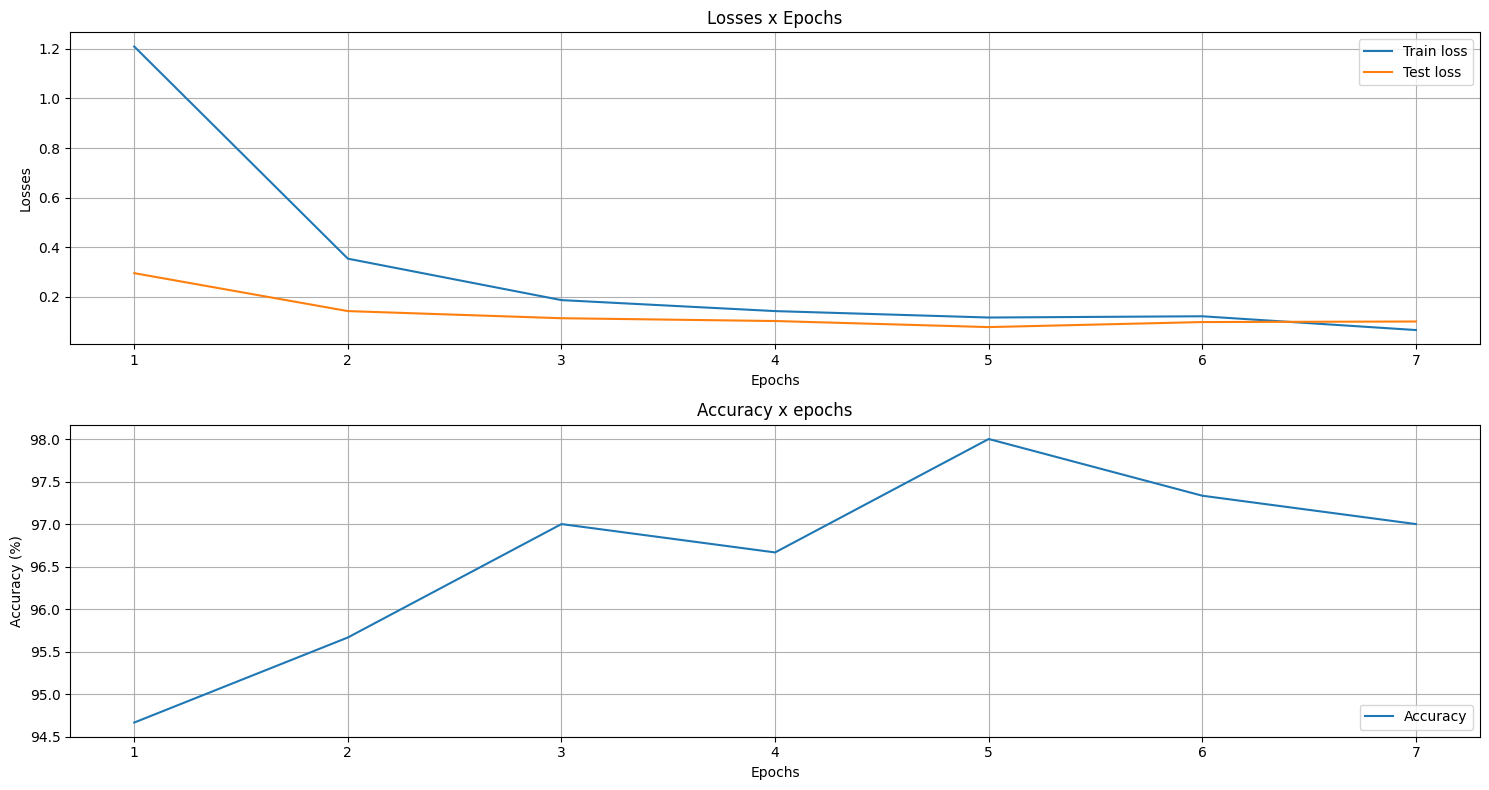

In [66]:
fig, axs = pyplot.subplots(2, figsize=(15,8))
axs[0].plot(range(1, epochs+1), list_train_loss,label="Train loss") #Plota o erro de treino X epocas
axs[0].plot(range(1, epochs+1), list_test_loss, label="Test loss") #Plota o erro de teste x epocas
axs[0].set(xticks=range(1, epochs+1))
axs[0].set_title('Losses x Epochs') #Define o título
axs[0].set(xlabel='Epochs') #Define o nome do eixo x
axs[0].set(ylabel='Losses') #Define o nome do eixo y
axs[0].legend() #Mostra a legenda
axs[0].grid(True) #Mostra a grade


axs[1].plot(range(1, epochs+1), list_acc, label='Accuracy') #Plota a acuracia para erro de 1 graus x epocas
axs[1].set(xticks=range(1, epochs+1))
axs[1].set_title('Accuracy x epochs') #Define o título
axs[1].set(xlabel='Epochs') #Define o nome do eixo x
axs[1].set(ylabel='Accuracy (%)') #Define o nome do eixo y
axs[1].legend(loc='lower right') #Mostra a legenda
axs[1].grid(True) #Mostra a grade

pyplot.tight_layout()

A validação da implementação do aluno ocorrerá da seguinte forma: forneceremos à rede (já treinada pelo aluno) o *dataset* de validação (`data_valid`) para que os exemplos contidos nele sejam classificados. Calcularemos, então, a acurácia na classificação desses exemplos.

A célula abaixo é responsável por efetuar esse cálculo.

Caso a **acurácia obtida seja maior ou igual a 95%** e o **tempo de execução da segunda época até o final do treinamento seja menor ou igual a 500 segundos**, a implementação do aluno será considerada satisfatória e lhe garantirá mais **30 pontos**.

In [67]:
total = 0
correct = 0
loss_valid = 0

for imagem_valid, label_valid in loader_valid:

	loss_v = 0

	imagem_valid, label_valid = imagem_valid.float().to(device), label_valid.to(device)
	outputs_valid = model(imagem_valid)
	_, previsao = torch.max(outputs_valid, dim = 1)
	loss_v = criterion (outputs_valid, label_valid.long())
	total = total + 1 #Adiciona +1 na variável que guarda o total de previsões feitas
	if previsao == label_valid:
		correct = correct + 1 #Soma +1 na variável que mede quantas previsões dessa categoria (erro absoluto de 2 graus) estão certas
	loss_valid += loss_v

loss_valid = loss_valid/len(loader_valid)
accuracy = (correct/total)*100 #Calcula a acurácia para erro absoluto de 1 grau em porcentagem

print('A acurácia obtida foi de: {:.2f}'.format(accuracy) + '%.')
print()
print('O erro médio obtido foi de: {:.4f}'.format(loss_valid))
print()
print('O tempo gasto durante o treinamento, excluindo a primeira época, foi de: {:.2f}'.format(TIME), 'segundos.')
print()

if accuracy > 95.0 and TIME < 500:
	print('Os resultados obtidos foram satisfatórios. Parabéns!')
elif accuracy > 95.0 and TIME > 500:
	print('A acurácia apresentou um valor satisfatório, mas o tempo de treinamento não. Tente otimizar este parâmetro.')
elif accuracy < 95.0 and TIME < 500:
	print('O tempo de treinamento apresentou um valor satisfatório, mas a acurácia não. Tente otimizar este parâmetro.')
else:
	print('Os valores demandados não foram alcançados. Tente otimizá-los para validar a sua submissão.')

A acurácia obtida foi de: 98.67%.

O erro médio obtido foi de: 0.0459

O tempo gasto durante o treinamento, excluindo a primeira época, foi de: 160.13 segundos.

Os resultados obtidos foram satisfatórios. Parabéns!
